In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import datetime
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
import joblib
warnings.filterwarnings("ignore")

## 思路

我还是和第二问题解一样的，先将预测出来的1月数据进行合并，再去构造19-2月的数据

然后预测出2月的数据

同样的，我们再构建二月数据时，还是剔除掉104区域的数据去构建

# 读取数据并合并

In [2]:
#读取经过处理的原本数据：
pd.options.display.max_columns=100 # to see columns 
df1 = pd.read_csv('data/proess_transform.csv',encoding='utf-8')
df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597356,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597357,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597358,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597359,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [3]:
# 读取预测出的构造的19-01月的数据：

df2 = pd.read_csv('output/构造的1月数据预测结果.csv',encoding='utf-8')
df2

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-21,102,21023,306,407,0,5.0,2018,12,21,0,0,1208,6,2,3,4,1
1,2018-12-21,101,20877,308,404,0,7.0,2018,12,21,0,0,1208,2,2,3,4,1
2,2018-12-21,105,20347,308,404,0,5.0,2018,12,21,0,0,1208,2,2,3,4,1
3,2018-12-21,102,20173,303,401,1,11.0,2018,12,21,0,0,1208,1,2,3,4,1
4,2018-12-21,101,20285,305,412,1,3.0,2018,12,21,0,0,1208,0,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [4]:
# df2[df2['销售区域编码']==104]  #查看一下是否剔除104成功

In [5]:
#拼接合并数据作为训练集：

df =pd.concat([df1,df2],axis=0)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [6]:
## 保存合并的数据：(包含了预测的19年01月需求量)
df.to_csv("data/proess_transform1.csv",index=False)

# 构造19年02月的数据：

In [7]:
#在 构造待预测数据之前，我们先剔除掉104地区的数据，因为不需要对该数据预测

temp = df[df['销售区域编码']!=104]
temp #减少了2w多数据 25053



,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
8,2015-09-02,102,20323,305,412,0,502.0,2015,9,2,0,0,2,0,0,2,2,1
9,2015-09-02,102,21350,305,412,0,107.0,2015,9,2,0,0,2,0,0,2,2,1
10,2015-09-02,101,20657,303,410,0,18.0,2015,9,2,0,0,2,6,0,2,2,1
11,2015-09-02,102,20457,305,412,0,308.0,2015,9,2,0,0,2,0,0,2,2,1
12,2015-09-03,102,21052,303,401,0,14.0,2015,9,3,1,0,3,5,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [8]:
# 构造19年02月的数据：
temp['组合'] = temp['销售区域编码'].astype(str)+'_'+temp['产品大类编码'].astype(str)+'_'+temp['产品细类编码'].astype(str)+'_'+temp['产品编码'].astype(str)
temp

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,组合
8,2015-09-02,102,20323,305,412,0,502.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20323
9,2015-09-02,102,21350,305,412,0,107.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_21350
10,2015-09-02,101,20657,303,410,0,18.0,2015,9,2,0,0,2,6,0,2,2,1,101_303_410_20657
11,2015-09-02,102,20457,305,412,0,308.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20457
12,2015-09-03,102,21052,303,401,0,14.0,2015,9,3,1,0,3,5,0,2,3,0,102_303_401_21052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1,103_303_401_20135
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1,105_302_408_20171
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1,105_306_407_20093
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1,103_308_404_21895


In [9]:
len(set(temp['组合']))  #5109种产品，104剔除成功

5109

In [10]:
#从2019-2-1到2019-2-28日的数据

dt1 = pd.date_range(start="20190201", end="20190228", freq="D")
dt1
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(temp['组合']))
    need = need+[0]*len(set(temp['组合']))
    ids=ids+list(set(temp['组合']))

In [11]:
tempdf=pd.DataFrame()
tempdf['订单日期']=dates
tempdf['组合']=ids
tempdf['订单需求量']=need
tempdf

,订单日期,组合,订单需求量
0,2019-02-01,102_302_408_20921,0
1,2019-02-01,101_306_407_21601,0
2,2019-02-01,102_302_408_20591,0
3,2019-02-01,101_306_407_21573,0
4,2019-02-01,105_302_408_21342,0
...,...,...,...
143047,2019-02-28,101_306_407_20312,0
143048,2019-02-28,105_303_401_20046,0
143049,2019-02-28,101_306_407_20820,0
143050,2019-02-28,101_302_408_21770,0


In [12]:
## chu处理tempdf为df的数据格式：

tempdf['销售区域编码']=tempdf['组合'].str.split('_',expand=True)[0]
tempdf['产品大类编码']=tempdf['组合'].str.split('_',expand=True)[1]
tempdf['产品细类编码']=tempdf['组合'].str.split('_',expand=True)[2]
tempdf['产品编码']=tempdf['组合'].str.split('_',expand=True)[3]
tempdf
import chinese_calendar
import datetime

tempdf['订单日期'] = pd.to_datetime(tempdf['订单日期'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.订单日期.dt.year #分解出年份
tempdf['Month'] = tempdf.订单日期.dt.month
tempdf['day'] = tempdf.订单日期.dt.day

tempdf

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf


,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日
0,2019-02-01,102_302_408_20921,0,102,302,408,20921,2019,2,1,0
1,2019-02-01,101_306_407_21601,0,101,306,407,21601,2019,2,1,0
2,2019-02-01,102_302_408_20591,0,102,302,408,20591,2019,2,1,0
3,2019-02-01,101_306_407_21573,0,101,306,407,21573,2019,2,1,0
4,2019-02-01,105_302_408_21342,0,105,302,408,21342,2019,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101_306_407_20312,0,101,306,407,20312,2019,2,28,0
143048,2019-02-28,105_303_401_20046,0,105,303,401,20046,2019,2,28,0
143049,2019-02-28,101_306_407_20820,0,101,306,407,20820,2019,2,28,0
143050,2019-02-28,101_302_408_21770,0,101,302,408,21770,2019,2,28,0


In [13]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日
0,2019-02-01,102_302_408_20921,0,102,302,408,20921,2019,2,1,0,0
1,2019-02-01,101_306_407_21601,0,101,306,407,21601,2019,2,1,0,0
2,2019-02-01,102_302_408_20591,0,102,302,408,20591,2019,2,1,0,0
3,2019-02-01,101_306_407_21573,0,101,306,407,21573,2019,2,1,0,0
4,2019-02-01,105_302_408_21342,0,105,302,408,21342,2019,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101_306_407_20312,0,101,306,407,20312,2019,2,28,0,0
143048,2019-02-28,105_303_401_20046,0,105,303,401,20046,2019,2,28,0,0
143049,2019-02-28,101_306_407_20820,0,101,306,407,20820,2019,2,28,0,0
143050,2019-02-28,101_302_408_21770,0,101,302,408,21770,2019,2,28,0,0


In [14]:
jagdf=temp[['组合','价格区间','销售渠道名称']]
jagdf.drop_duplicates(['组合'],keep='last',inplace=True)
jagdf
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['组合'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['组合'])[i]] = list(jagdf['销售渠道名称'])[i]
dict_jg
qudao_dict
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['组合']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['销售渠道名称']=qudao
tempdf


,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称
0,2019-02-01,102_302_408_20921,0,102,302,408,20921,2019,2,1,0,0,1,0
1,2019-02-01,101_306_407_21601,0,101,306,407,21601,2019,2,1,0,0,1,0
2,2019-02-01,102_302_408_20591,0,102,302,408,20591,2019,2,1,0,0,0,0
3,2019-02-01,101_306_407_21573,0,101,306,407,21573,2019,2,1,0,0,1,1
4,2019-02-01,105_302_408_21342,0,105,302,408,21342,2019,2,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101_306_407_20312,0,101,306,407,20312,2019,2,28,0,0,2,0
143048,2019-02-28,105_303_401_20046,0,105,303,401,20046,2019,2,28,0,0,5,0
143049,2019-02-28,101_306_407_20820,0,101,306,407,20820,2019,2,28,0,0,3,1
143050,2019-02-28,101_302_408_21770,0,101,302,408,21770,2019,2,28,0,0,1,1


In [15]:
tempdf['标签'] = "空"


for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['订单日期'] < pd.to_datetime(end) and row['订单日期'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['订单日期']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf
tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
tempdf
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段
0,2019-02-01,102_302_408_20921,0,102,302,408,20921,2019,2,1,0,0,1,0,月初,冬季,3,0
1,2019-02-01,101_306_407_21601,0,101,306,407,21601,2019,2,1,0,0,1,0,月初,冬季,3,0
2,2019-02-01,102_302_408_20591,0,102,302,408,20591,2019,2,1,0,0,0,0,月初,冬季,3,0
3,2019-02-01,101_306_407_21573,0,101,306,407,21573,2019,2,1,0,0,1,1,月初,冬季,3,0
4,2019-02-01,105_302_408_21342,0,105,302,408,21342,2019,2,1,0,0,2,0,月初,冬季,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101_306_407_20312,0,101,306,407,20312,2019,2,28,0,0,2,0,月末,冬季,3,2
143048,2019-02-28,105_303_401_20046,0,105,303,401,20046,2019,2,28,0,0,5,0,月末,冬季,3,2
143049,2019-02-28,101_306_407_20820,0,101,306,407,20820,2019,2,28,0,0,3,1,月末,冬季,3,2
143050,2019-02-28,101_302_408_21770,0,101,302,408,21770,2019,2,28,0,0,1,1,月末,冬季,3,2


In [16]:
tempdf['星期几'] = tempdf.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['订单日期'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf
tempdf.drop(['标签','season','组合'],axis=1,inplace=True)
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday
0,2019-02-01,0,102,302,408,20921,2019,2,1,0,0,1,0,3,0,4,1
1,2019-02-01,0,101,306,407,21601,2019,2,1,0,0,1,0,3,0,4,1
2,2019-02-01,0,102,302,408,20591,2019,2,1,0,0,0,0,3,0,4,1
3,2019-02-01,0,101,306,407,21573,2019,2,1,0,0,1,1,3,0,4,1
4,2019-02-01,0,105,302,408,21342,2019,2,1,0,0,2,0,3,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,0,101,306,407,20312,2019,2,28,0,0,2,0,3,2,3,1
143048,2019-02-28,0,105,303,401,20046,2019,2,28,0,0,5,0,3,2,3,1
143049,2019-02-28,0,101,306,407,20820,2019,2,28,0,0,3,1,3,2,3,1
143050,2019-02-28,0,101,302,408,21770,2019,2,28,0,0,1,1,3,2,3,1


In [17]:
dt1 = pd.date_range(start="20150901", end="20190228", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in tempdf['订单日期']:
#     print(dicts[str(dat).split(' ')[0]])
    Ds.append(dicts[str(dat).split(' ')[0]])
tempdf['D'] = Ds
tempdf
df_sub=tempdf[['订单日期', '销售区域编码', '产品编码', '产品大类编码', '产品细类编码', '销售渠道名称', '订单需求量', 'Year',
       'Month', 'day', '是否节假日', '是否促销日', 'D', '价格区间', '每月时间段', 'season_bm',
       '星期几', 'is_workday',]]
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-02-01,102,20921,302,408,0,0,2019,2,1,0,0,1250,1,0,3,4,1
1,2019-02-01,101,21601,306,407,0,0,2019,2,1,0,0,1250,1,0,3,4,1
2,2019-02-01,102,20591,302,408,0,0,2019,2,1,0,0,1250,0,0,3,4,1
3,2019-02-01,101,21573,306,407,1,0,2019,2,1,0,0,1250,1,0,3,4,1
4,2019-02-01,105,21342,302,408,0,0,2019,2,1,0,0,1250,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,0,2019,2,28,0,0,1277,1,2,3,3,1


In [18]:
df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]] = df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143052 entries, 0 to 143051
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        143052 non-null  datetime64[ns]
 1   销售区域编码      143052 non-null  int64         
 2   产品编码        143052 non-null  int64         
 3   产品大类编码      143052 non-null  int64         
 4   产品细类编码      143052 non-null  int64         
 5   销售渠道名称      143052 non-null  int64         
 6   订单需求量       143052 non-null  int64         
 7   Year        143052 non-null  int64         
 8   Month       143052 non-null  int64         
 9   day         143052 non-null  int64         
 10  是否节假日       143052 non-null  int64         
 11  是否促销日       143052 non-null  int64         
 12  D           143052 non-null  int64         
 13  价格区间        143052 non-null  category      
 14  每月时间段       143052 non-null  int64         
 15  season_bm   143052 non-null  int64         
 16  星期

In [19]:
# b保存一下构造的19年2月数据：
df_sub.to_csv('data/构造19_02data.csv',index=False,)

In [20]:
# df.drop('zuhe',axis=1,inplace=True)  #删除df的无用列
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [21]:
df1 =pd.concat([df,df_sub],axis=0)
df1.reset_index(drop=True)
df1 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28 00:00:00,101,20312,306,407,0,0.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28 00:00:00,105,20046,303,401,0,0.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28 00:00:00,101,20820,306,407,1,0.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28 00:00:00,101,21770,302,408,1,0.0,2019,2,28,0,0,1277,1,2,3,3,1


In [22]:
df1 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28 00:00:00,101,20312,306,407,0,0.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28 00:00:00,105,20046,303,401,0,0.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28 00:00:00,101,20820,306,407,1,0.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28 00:00:00,101,21770,302,408,1,0.0,2019,2,28,0,0,1277,1,2,3,3,1


In [23]:
del df 

df = df1
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28 00:00:00,101,20312,306,407,0,0.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28 00:00:00,105,20046,303,401,0,0.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28 00:00:00,101,20820,306,407,1,0.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28 00:00:00,101,21770,302,408,1,0.0,2019,2,28,0,0,1277,1,2,3,3,1


# 特征工程

## 滞后特征

In [24]:
#Introduce lags
lags = [1,2,3,6,12,24,36,48,60]
for lag in lags:
    df['need_lag_'+str(lag)] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(lag).astype(np.float16)

## 均值编码

In [25]:
df['产品编码_avg'] = df.groupby('产品编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby('销售区域编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('产品大类编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('产品细类编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('销售渠道名称')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['产品编码','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['产品大类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['产品细类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['销售渠道名称','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['销售区域编码','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['销售渠道名称','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)



df['年_月_need_avg'] = df.groupby(['Year','Month'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售区域编码_need_avg'] = df.groupby(['Year','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品大类编码_need_avg'] = df.groupby(['Year','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品细类编码_need_avg'] = df.groupby(['Year','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售渠道名称_need_avg'] = df.groupby(['Year','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['月_销售区域编码_need_avg'] = df.groupby(['Month','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品大类编码_need_avg'] = df.groupby(['Month','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品细类编码_need_avg'] = df.groupby(['Month','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_销售渠道名称_need_avg'] = df.groupby(['Month','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)

df['每月时间段_销售区域编码_need_avg'] = df.groupby(['销售区域编码','每月时间段'])['订单需求量'].transform('mean').astype(np.float16)

df['价格区间_销售区域编码_need_avg'] = df.groupby(['销售区域编码','价格区间'])['订单需求量'].transform('mean').astype(np.float16)

## 滑动窗口统计

In [26]:
df['rolling_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 开窗数据拓展

In [27]:
df['expanding_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## 需求趋势构建

In [28]:
df['daily_avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码','D'])['订单需求量'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['need_trend'] = (df['daily_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['daily_avg_need','avg_need'],axis=1,inplace=True)

In [29]:
df.drop('订单日期',axis=1,inplace=True)
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.56250,73.00000,73.000,53.1875,12.289062,12.289062,12.289062,12.664062,102.875000,73.000,66.87500,107.6875,111.062500,116.625000,116.625000,106.000000,103.750000,110.750000,110.750000,73.875000,92.62500,61.28125,NaN,NaN,6.710938
1,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.367188,94.56250,57.37500,57.375,53.1875,9.000000,4.367188,4.367188,4.367188,86.812500,57.375,33.46875,107.6875,111.062500,84.437500,84.437500,106.000000,103.750000,70.437500,70.437500,73.875000,92.62500,61.28125,NaN,NaN,3.000000
2,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.937500,94.56250,73.00000,73.000,75.0000,130.125000,111.937500,111.937500,131.875000,102.875000,73.000,84.37500,107.6875,111.062500,116.625000,116.625000,153.250000,103.750000,110.750000,110.750000,123.875000,92.62500,120.18750,NaN,NaN,-21.125000
3,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.187500,94.56250,77.25000,77.250,75.0000,100.500000,67.187500,67.187500,67.187500,102.500000,77.250,87.43750,107.6875,111.062500,138.250000,138.250000,153.250000,103.750000,98.562500,98.562500,123.875000,92.62500,91.68750,NaN,NaN,-97.500000
4,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.56250,73.00000,73.000,53.1875,10.710938,10.710938,10.710938,12.164062,102.875000,73.000,66.87500,107.6875,111.062500,116.625000,116.625000,106.000000,103.750000,110.750000,110.750000,73.875000,92.62500,68.18750,NaN,NaN,-7.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,101,20312,306,407,0,0.0,2019,2,28,0,0,1277,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,32.562500,58.43750,75.81250,71.500,53.1875,14.703125,32.562500,32.562500,32.625000,76.062500,71.500,68.87500,0.0000,3.292969,3.642578,3.566406,3.330078,13.492188,20.921875,18.937500,13.734375,55.37500,79.56250,0.0,14.703125,-14.703125
143048,105,20046,303,401,0,0.0,2019,2,28,0,0,1277,5,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,4.398438,56.84375,31.28125,37.000,53.1875,3.000000,4.398438,4.398438,4.398438,34.375000,37.000,33.93750,0.0000,3.560547,3.492188,3.562500,3.330078,15.484375,6.992188,8.687500,13.734375,53.28125,38.71875,0.0,3.000000,-3.000000
143049,101,20820,306,407,1,0.0,2019,2,28,0,0,1277,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,74.0,89.0,35.0,325.000000,58.43750,75.81250,71.500,75.0000,552.500000,325.000000,325.000000,331.500000,76.062500,71.500,81.06250,0.0000,3.292969,3.642578,3.566406,4.140625,13.492188,20.921875,18.937500,17.859375,55.37500,47.12500,0.0,552.500000,-552.500000
143050,101,21770,302,408,1,0.0,2019,2,28,0,0,1277,1,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,8.226562,58.43750,37.25000,37.250,75.0000,3.800781,8.226562,8.226562,9.953125,26.421875,37.250,56.96875,0.0000,3.292969,3.343750,3.343750,4.140625,13.492188,8.023438,8.023438,17.859375,55.37500,93.56250,0.0,3.800781,-3.800781


In [30]:
df = df[df['D']>=60]
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
14994,102,22047,306,407,0,99.0,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,48.250000,56.90625,75.81250,71.50,53.1875,48.375000,48.250000,48.250000,50.156250,81.625000,71.50,68.875000,111.9375,102.250000,155.750000,143.750000,106.000000,79.812500,131.625000,121.312500,77.250000,53.09375,39.65625,63.71875,52.218750,50.625000
14995,103,21469,302,408,0,47.0,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.062500,59.28125,37.25000,37.25,53.1875,20.984375,86.062500,86.062500,86.062500,46.156250,37.25,31.359375,111.9375,105.125000,83.500000,83.500000,106.000000,96.625000,78.562500,78.562500,77.250000,55.71875,92.31250,NaN,NaN,26.015625
14996,103,21295,302,408,0,10.0,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,68.375000,59.28125,37.25000,37.25,53.1875,103.875000,68.375000,68.375000,73.687500,46.156250,37.25,31.359375,111.9375,105.125000,83.500000,83.500000,106.000000,96.625000,78.562500,78.562500,77.250000,55.71875,68.75000,91.00000,123.187500,-45.875000
14997,103,20765,302,408,0,46.0,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.375000,59.28125,37.25000,37.25,53.1875,14.937500,21.375000,21.375000,24.718750,46.156250,37.25,31.359375,111.9375,105.125000,83.500000,83.500000,106.000000,96.625000,78.562500,78.562500,77.250000,55.71875,92.31250,NaN,NaN,31.062500
14998,103,20591,302,408,0,33.0,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,83.875000,59.28125,37.25000,37.25,53.1875,58.312500,83.875000,83.875000,95.437500,46.156250,37.25,31.359375,111.9375,105.125000,83.500000,83.500000,106.000000,96.625000,78.562500,78.562500,77.250000,55.71875,101.93750,37.43750,118.562500,-27.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,101,20312,306,407,0,0.0,2019,2,28,0,0,1277,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,32.562500,58.43750,75.81250,71.50,53.1875,14.703125,32.562500,32.562500,32.625000,76.062500,71.50,68.875000,0.0000,3.292969,3.642578,3.566406,3.330078,13.492188,20.921875,18.937500,13.734375,55.37500,79.56250,0.00000,14.703125,-14.703125
143048,105,20046,303,401,0,0.0,2019,2,28,0,0,1277,5,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,4.398438,56.84375,31.28125,37.00,53.1875,3.000000,4.398438,4.398438,4.398438,34.375000,37.00,33.937500,0.0000,3.560547,3.492188,3.562500,3.330078,15.484375,6.992188,8.687500,13.734375,53.28125,38.71875,0.00000,3.000000,-3.000000
143049,101,20820,306,407,1,0.0,2019,2,28,0,0,1277,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,74.0,89.0,35.0,325.000000,58.43750,75.81250,71.50,75.0000,552.500000,325.000000,325.000000,331.500000,76.062500,71.50,81.062500,0.0000,3.292969,3.642578,3.566406,4.140625,13.492188,20.921875,18.937500,17.859375,55.37500,47.12500,0.00000,552.500000,-552.500000
143050,101,21770,302,408,1,0.0,2019,2,28,0,0,1277,1,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,8.226562,58.43750,37.25000,37.25,75.0000,3.800781,8.226562,8.226562,9.953125,26.421875,37.25,56.968750,0.0000,3.292969,3.343750,3.343750,4.140625,13.492188,8.023438,8.023438,17.859375,55.37500,93.56250,0.00000,3.800781,-3.800781


In [31]:
df.to_pickle('data4_7.pkl')
del df

# 建立模型

In [32]:
data = pd.read_pickle('data4_7.pkl')
valid = data[(data['D']>=1188) & (data['D']<1250)][['产品编码','D','订单需求量']]
test = data[data['D']>=1250][['产品编码','D','订单需求量']]   #作为待预测的数据
eval_preds = test['订单需求量']    ## 待预测 目前全为0
valid_preds = valid['订单需求量']  #这是已有真实标签需求量1188到1248，天间隔61天，两个月的真实数据

In [33]:
states = list(set(data['销售区域编码']))
states

[101, 102, 103, 104, 105]

In [34]:
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False

In [35]:
# 画出损失函数的变化情况
def plot_logloss(model,model_name):
    results = model.evals_result_
#     print(results)
    epochs = len(results['training']['rmse'])
    x_axis = range(0, epochs)
#     print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['rmse'], label='训练集')
#     print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['valid_1']['rmse'], label='测试集')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('{}LightGBM RMSE'.format(model_name))
    plt.savefig('{}LightGBM rmse'.format(model_name),dpi=200)
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['mape'], label='训练集')
    ax.plot(x_axis, results['valid_1']['mape'], label='测试集')
    ax.legend()
    plt.ylabel('MAPE')
    plt.title('{}LightGBM MAPE'.format(model_name))
    plt.savefig('{}LightGBM mape'.format(model_name),dpi=200)
    plt.show()

*****Prediction for 销售区域: 101*****
[10]	training's rmse: 106.201	training's mape: 1.55355	training's l2: 11278.7	valid_1's rmse: 8.19112	valid_1's mape: 1.18611	valid_1's l2: 67.0944
[20]	training's rmse: 100.822	training's mape: 1.37727	training's l2: 10165.1	valid_1's rmse: 7.39138	valid_1's mape: 0.819053	valid_1's l2: 54.6325
[30]	training's rmse: 98.3064	training's mape: 1.34058	training's l2: 9664.14	valid_1's rmse: 7.17598	valid_1's mape: 0.540146	valid_1's l2: 51.4946
[40]	training's rmse: 96.4233	training's mape: 1.32694	training's l2: 9297.46	valid_1's rmse: 7.12997	valid_1's mape: 0.530209	valid_1's l2: 50.8364


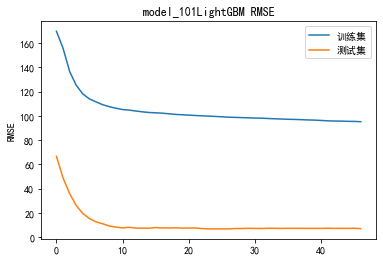

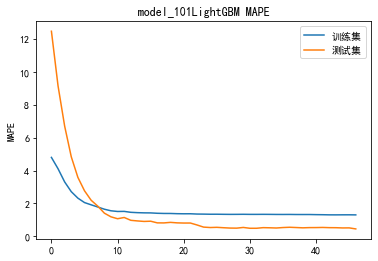

*****Prediction for 销售区域: 102*****
[10]	training's rmse: 81.472	training's mape: 1.3729	training's l2: 6637.69	valid_1's rmse: 5.84198	valid_1's mape: 0.968756	valid_1's l2: 34.1287
[20]	training's rmse: 77.2669	training's mape: 1.22049	training's l2: 5970.17	valid_1's rmse: 3.88801	valid_1's mape: 0.506753	valid_1's l2: 15.1166
[30]	training's rmse: 75.4012	training's mape: 1.20477	training's l2: 5685.34	valid_1's rmse: 4.1691	valid_1's mape: 0.531077	valid_1's l2: 17.3814
[40]	training's rmse: 73.9643	training's mape: 1.18765	training's l2: 5470.71	valid_1's rmse: 4.5239	valid_1's mape: 0.582051	valid_1's l2: 20.4656


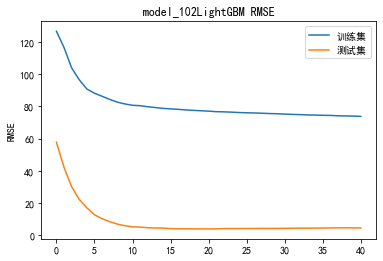

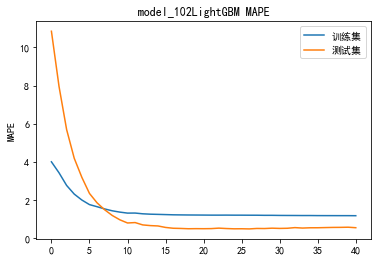

*****Prediction for 销售区域: 103*****
[10]	training's rmse: 106.869	training's mape: 1.60841	training's l2: 11420.9	valid_1's rmse: 6.96089	valid_1's mape: 0.844713	valid_1's l2: 48.454
[20]	training's rmse: 102.29	training's mape: 1.42011	training's l2: 10463.2	valid_1's rmse: 5.99512	valid_1's mape: 0.523752	valid_1's l2: 35.9415
[30]	training's rmse: 99.6034	training's mape: 1.39677	training's l2: 9920.83	valid_1's rmse: 6.47415	valid_1's mape: 0.46362	valid_1's l2: 41.9146


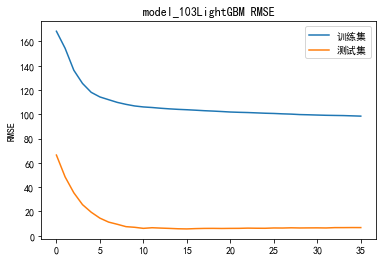

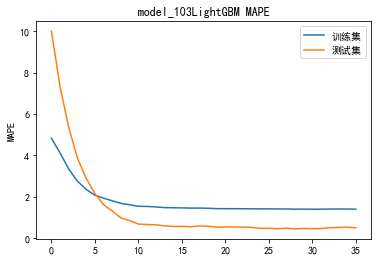

*****Prediction for 销售区域: 104*****
*****Prediction for 销售区域: 105*****
[10]	training's rmse: 99.7831	training's mape: 1.69182	training's l2: 9956.66	valid_1's rmse: 5.9466	valid_1's mape: 0.894534	valid_1's l2: 35.362
[20]	training's rmse: 93.9643	training's mape: 1.48162	training's l2: 8829.28	valid_1's rmse: 4.30105	valid_1's mape: 0.457476	valid_1's l2: 18.499
[30]	training's rmse: 91.3313	training's mape: 1.44339	training's l2: 8341.4	valid_1's rmse: 4.52884	valid_1's mape: 0.458436	valid_1's l2: 20.5104


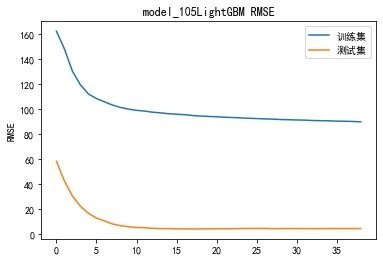

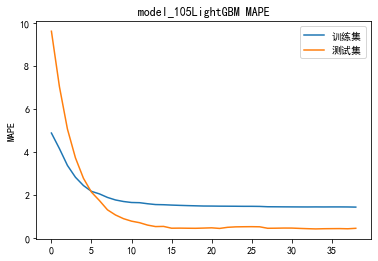

In [36]:
for store in states:
    try:
        df = data[data['销售区域编码']==store]

        #Split the data
        X_train, y_train = df[df['D']<1208].drop('订单需求量',axis=1), df[df['D']<1208]['订单需求量']
        X_valid, y_valid = df[(df['D']>=1208) & (df['D']<1250)].drop('订单需求量',axis=1), df[(df['D']>=1208) & (df['D']<1250)]['订单需求量']
        X_test = df[df['D']>=1250].drop('订单需求量',axis=1)

        #Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for 销售区域: {}*****'.format(store))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse,mape', verbose=10, early_stopping_rounds=20)
        valid_preds[X_valid.index] = model.predict(X_valid)
        eval_preds[X_test.index] = model.predict(X_test)
        filename = "models/" + "model_"+ str(store) + ".pkl"
        # save model
        joblib.dump(model, filename)
        plot_logloss(model,"model_"+ str(store))
        del model, X_train, y_train, X_valid, y_valid
    except:
        del model, X_train, y_train, X_valid, y_valid
        continue

# 模型验证

In [37]:
model = joblib.load("models/model_101.pkl")
model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.8)

In [38]:
df = data[data['销售区域编码']==101]
X_valid, y_valid = df[(df['D']>=1208) & (df['D']<1249)].drop('订单需求量',axis=1), df[(df['D']>=1208) & (df['D']<1249)]['订单需求量']
y_valid

1         7.0
4         3.0
7         0.0
13        4.0
15        6.0
         ... 
209441    6.0
209443    6.0
209450    3.0
209453    6.0
209462    6.0
Name: 订单需求量, Length: 53054, dtype: float64

In [39]:
for v in y_valid:
    if v <=0 :
        print(v)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [40]:
s = model.predict(X_valid)
s

array([ 1.50157037,  3.82772578, 11.22857172, ...,  5.04024387,
        6.61741616,  5.64548438])

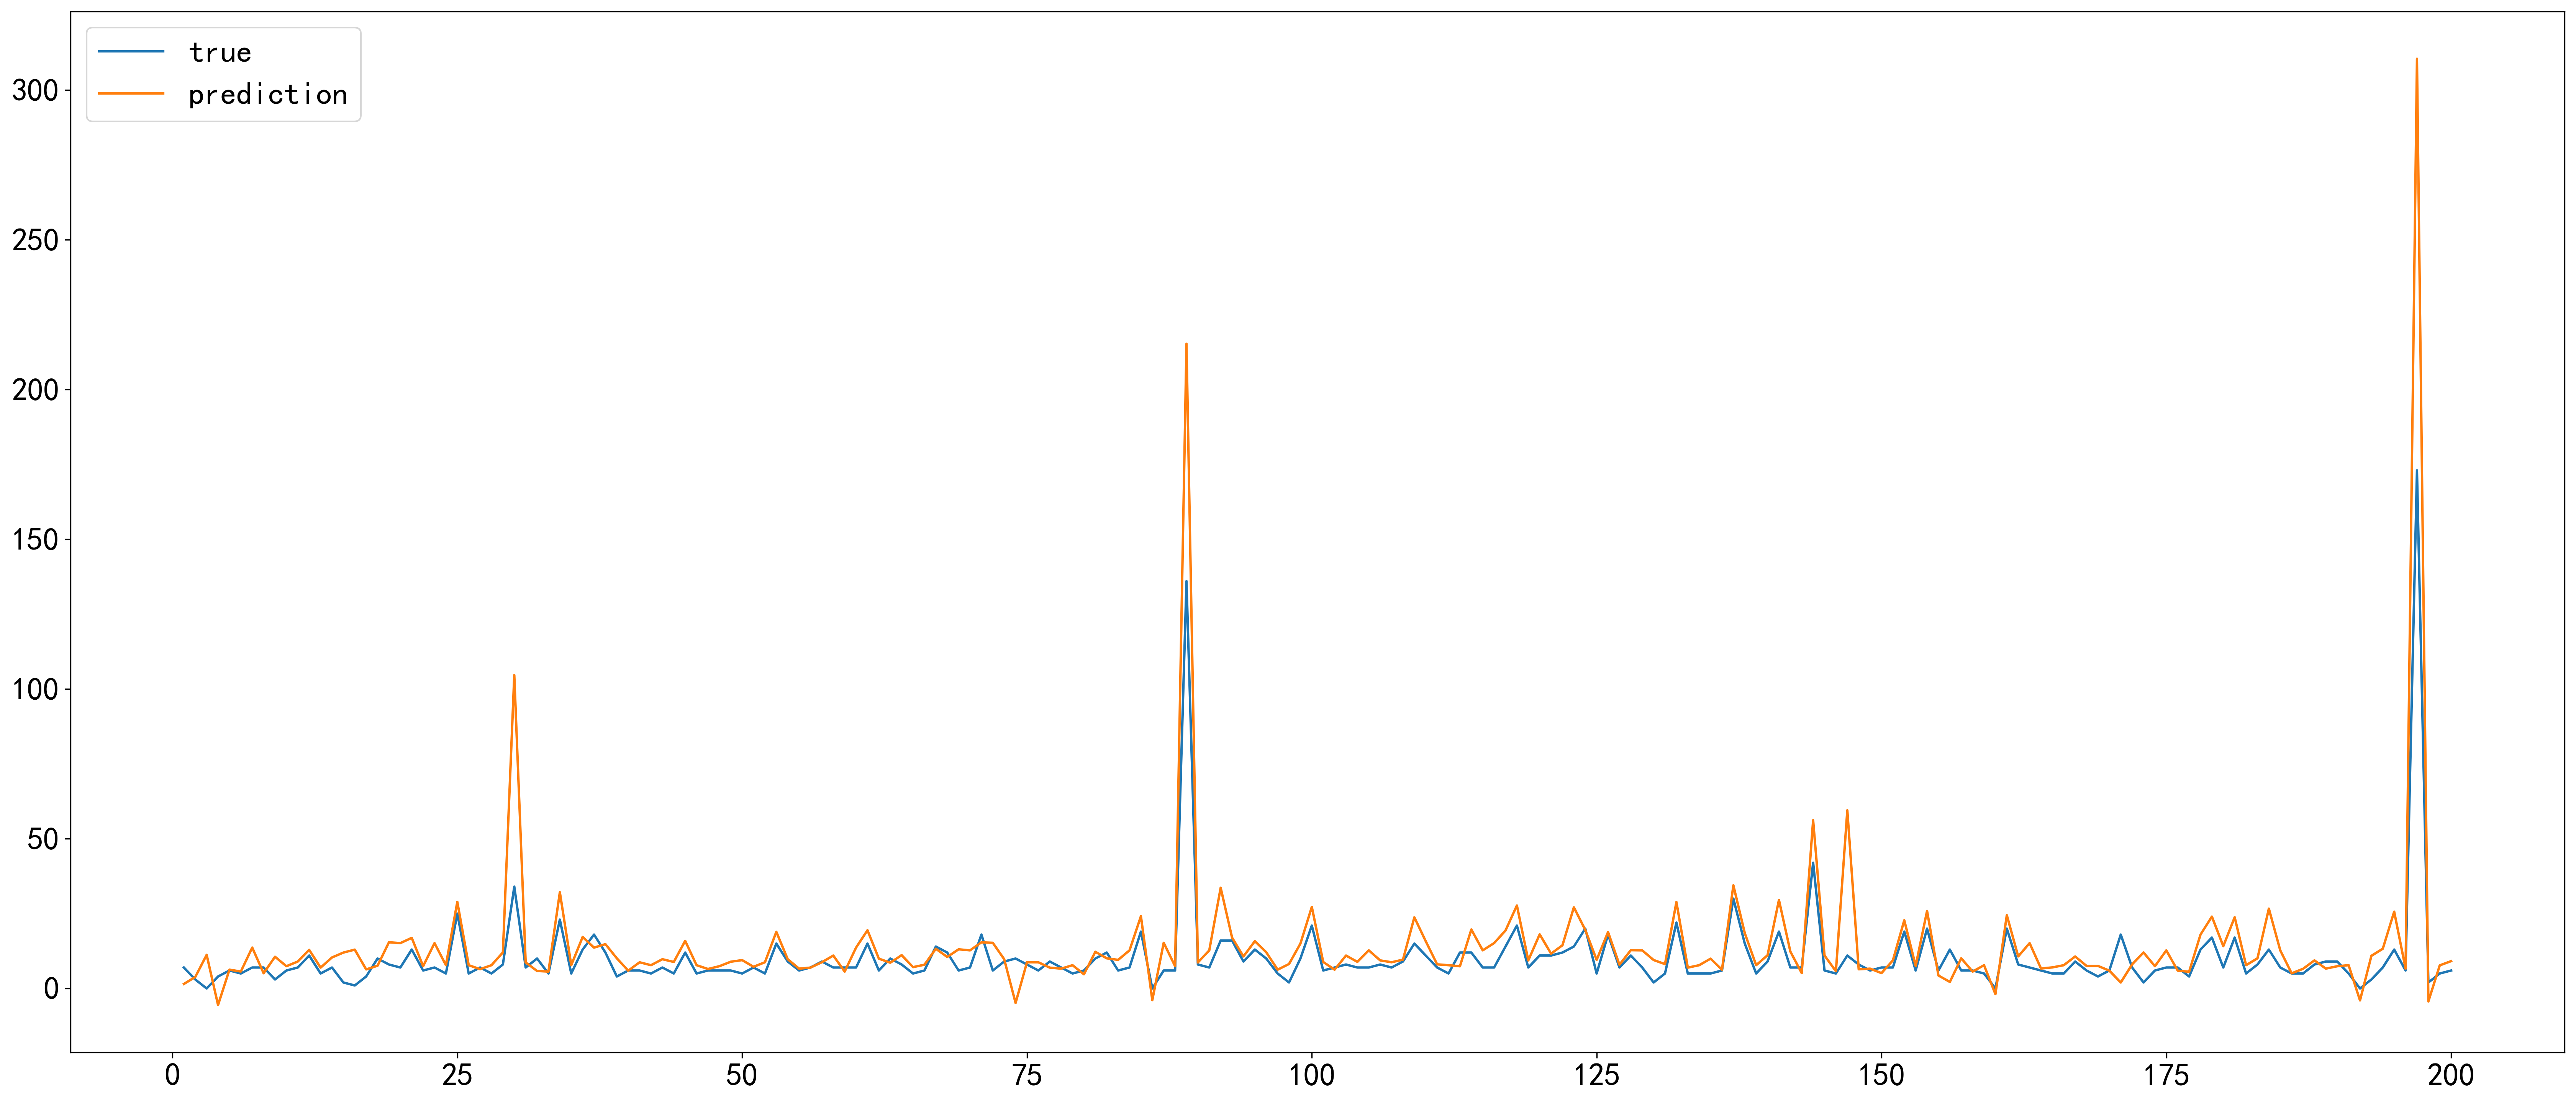

In [41]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:200],y_valid[:200])
plt.plot(x_axis[:200],s[:200])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

# 预测样例数据结果

In [42]:
eval_preds  ##y预测出来19-02月的值

0          7.425499
1          2.827895
2          3.993599
3          7.609243
4          7.449068
            ...    
143047     5.645484
143048     7.449068
143049    38.405739
143050     7.134859
143051     8.928696
Name: 订单需求量, Length: 143052, dtype: float64

In [43]:
result=[]
for v in eval_preds:
    if v<0:
        result.append(0)  #预测值里有负值，这是不可能的，所有我们用0来代表异常值，产生这负数多半是因为训练时，对应产品的时间序列数据很少
    else:
        result.append(round(v,0))


In [44]:
## d读取之前构造好的19年2月数据：
df_sub= pd.read_csv('data/构造19_02data.csv')
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-02-01,102,20921,302,408,0,0,2019,2,1,0,0,1250,1,0,3,4,1
1,2019-02-01,101,21601,306,407,0,0,2019,2,1,0,0,1250,1,0,3,4,1
2,2019-02-01,102,20591,302,408,0,0,2019,2,1,0,0,1250,0,0,3,4,1
3,2019-02-01,101,21573,306,407,1,0,2019,2,1,0,0,1250,1,0,3,4,1
4,2019-02-01,105,21342,302,408,0,0,2019,2,1,0,0,1250,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,0,2019,2,28,0,0,1277,1,2,3,3,1


## 将预测的各产品19年二月需求量值进行替换

In [45]:
df_sub['订单需求量'] = result  #把预测的订单需求量替换
df_sub.to_csv('output/构造的2月数据预测结果.csv',index=False)
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-02-01,102,20921,302,408,0,7.0,2019,2,1,0,0,1250,1,0,3,4,1
1,2019-02-01,101,21601,306,407,0,3.0,2019,2,1,0,0,1250,1,0,3,4,1
2,2019-02-01,102,20591,302,408,0,4.0,2019,2,1,0,0,1250,0,0,3,4,1
3,2019-02-01,101,21573,306,407,1,8.0,2019,2,1,0,0,1250,1,0,3,4,1
4,2019-02-01,105,21342,302,408,0,7.0,2019,2,1,0,0,1250,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1


In [46]:
result_df = df_sub[['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]  #筛选出需要的列

result_df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
0,2019-02-01,102,20921,302,408,7.0
1,2019-02-01,101,21601,306,407,3.0
2,2019-02-01,102,20591,302,408,4.0
3,2019-02-01,101,21573,306,407,8.0
4,2019-02-01,105,21342,302,408,7.0
...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,6.0
143048,2019-02-28,105,20046,303,401,7.0
143049,2019-02-28,101,20820,306,407,38.0
143050,2019-02-28,101,21770,302,408,7.0


## 制作透视表，计算各产品二月的总需求量

In [47]:
#制作透视表得到所有产品19年1月的需求量
result_df = pd.pivot_table(result_df, index=['销售区域编码','产品大类编码','产品细类编码','产品编码'], columns='订单日期',
                                  values='订单需求量', aggfunc=np.sum,fill_value=0).reset_index()
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28
0,101,301,405,20003,13,13,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
1,101,301,405,20027,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2,101,301,405,20085,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,101,301,405,20219,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
5105,105,308,404,22005,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
5106,105,308,404,22018,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [48]:
result_df['2月总需求量'] = result_df.iloc[:,4:].sum(axis=1)  # 对0，1列按行求和，生成新列
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2月总需求量
0,101,301,405,20003,13,13,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,312
1,101,301,405,20027,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,252
2,101,301,405,20085,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,168
3,101,301,405,20219,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,168
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,196
5105,105,308,404,22005,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,196
5106,105,308,404,22018,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,196
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,196


In [49]:
result_df = result_df[['销售区域编码','产品大类编码','产品细类编码','产品编码','2月总需求量']]
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2月总需求量
0,101,301,405,20003,312
1,101,301,405,20027,252
2,101,301,405,20085,168
3,101,301,405,20219,168
4,101,301,405,20270,168
...,...,...,...,...,...
5104,105,308,404,21981,196
5105,105,308,404,22005,196
5106,105,308,404,22018,196
5107,105,308,404,22023,196


## 求每种产销售区域编码-品大类编码-产品细类编码的预测需求量的均值，作为新产品的预测值

In [50]:
new = result_df[['销售区域编码','产品大类编码','产品细类编码','2月总需求量']].groupby(['销售区域编码','产品大类编码','产品细类编码',]).mean().reset_index()
new

订单日期,销售区域编码,产品大类编码,产品细类编码,2月总需求量
0,101,301,405,210.166667
1,101,302,408,187.015209
2,101,303,401,183.006173
3,101,303,406,166.000000
4,101,303,410,173.384615
5,101,303,411,172.000000
6,101,304,409,225.333333
7,101,305,412,164.130178
8,101,306,402,344.857143
9,101,306,407,182.522613


## 读入predict_sku1.csv，进行匹配汇总，得到结果

In [51]:
# 读入predict_sku0.csv，进行匹配汇总，predict_sku0中的产品的1月需求量：
predict_df =pd.read_csv("../B题-全部数据//predict_sku1.csv")
predict_df.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码',]
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [52]:

s=pd.merge(predict_df,result_df,how='left')


s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,2月总需求量
0,101,20002,303,406,168.0
1,101,20003,301,405,312.0
2,101,20006,307,403,168.0
3,101,20011,303,401,NaN
4,101,20014,307,403,84.0
...,...,...,...,...,...
2614,105,22066,307,403,28.0
2615,105,22072,305,412,252.0
2616,105,22075,307,403,NaN
2617,105,22083,303,401,280.0


## 将新产品以预测同类型的产品的均值填充

In [53]:
xuqiu = []
for index,row in s.iterrows():
    if np.isnan(row['2月总需求量']):
#         print( row['1月总需求量'])
        
        t=int(new.loc[(new['销售区域编码']==row['销售区域编码'])&(new['产品大类编码']==row['产品大类编码'])&(new['产品细类编码']==row['产品细类编码'])]['2月总需求量'])
        xuqiu.append(t)
    else:
        xuqiu.append(int(row['2月总需求量']))
s['2月总需求量'] = xuqiu
s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,2月总需求量
0,101,20002,303,406,168
1,101,20003,301,405,312
2,101,20006,307,403,168
3,101,20011,303,401,183
4,101,20014,307,403,84
...,...,...,...,...,...
2614,105,22066,307,403,28
2615,105,22072,305,412,252
2616,105,22075,307,403,212
2617,105,22083,303,401,280


In [68]:
s.to_csv('output/样本数据预测的2月predict_sku1.csv',index=False)